# Simmulated annealing for solving traveling salesman problem.

The algorythm used:
https://github.com/perrygeo/simanneal

Dataset Djibouti.
http://www.math.uwaterloo.ca/tsp/world/countries.html

In [156]:
import math
import time
import random
import pandas as pd
import numpy as np
from simanneal import Annealer
import matplotlib.pyplot as plt

### I. Definition of necessary classes and functions

In [157]:
class TravellingSalesmanProblem(Annealer):

    """Test annealer with a travelling salesman problem.
    """

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!
        self.stats = pd.DataFrame(columns=['Temp', 'Energy', 'Accept', 'Improve', 'Time'])

    def move(self):
        """Swaps two cities in the route."""
        # no efficiency gain, just proof of concept
        # demonstrates returning the delta energy (optional)
        initial_energy = self.energy()

        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

        return self.energy() - initial_energy

    def energy(self):
        """Calculates the length of the route."""
        e = 0
        for i in range(len(self.state)):
            e += self.distance_matrix[self.state[i-1]][self.state[i]]
        return e
    

    
    def update(self, step, T, E, acceptance, improvement):
        """Save statistics for each iteration"""

        elapsed = time.time() - self.start
        if step == 0:
            self.stats.loc[0] = [T, E, None, None, elapsed]
        else:
            remain = (self.steps - step) * (elapsed / step)
            self.stats.loc[step] = [T, E, acceptance, improvement, elapsed]


In [158]:
def distance(a, b):
    """Calculates distance between two latitude-longitude coordinates."""
    R = 3963  # radius of Earth (miles)
    lat1, lon1 = math.radians(a.latitude), math.radians(a.longitude)
    lat2, lon2 = math.radians(b.latitude), math.radians(b.longitude)
    return math.acos(math.sin(lat1) * math.sin(lat2) +
                     math.cos(lat1) * math.cos(lat2) * math.cos(lon1 - lon2)) * R


In [159]:
def getDistances(coordinates):
    """Generates distance matrics for a given locations list"""
    matrix = {}
    for c1 in coordinates.iterrows():
        matrix[c1[0]] = {}
        for c2 in coordinates.iterrows():
            if c1[0] == c2[0]:
                matrix[c1[0]][c2[0]] = 0.0
            else:
                matrix[c1[0]][c2[0]] = distance(c1[1], c2[1])
    return matrix

In [175]:
def annealTSP(init_state, distance_matrix, Tmax=25000.0, Tmin=0.01, steps=200000, updates=1000):
    """Process the locations with a simulated annealing algorythm"""
    begin = time.time()

    tsp = TravellingSalesmanProblem(init_state, distance_matrix)
    tsp.Tmax = Tmax
    tsp.Tmin = Tmin
    tsp.steps = steps
    tsp.updates = updates
    sequence, e = tsp.anneal()
    

    while sequence[0] != 0:
        sequence = sequence[1:] + sequence[:1]  
        
    print("%i mile route:" % e)
    print(" ➞  ".join([str(i) for i in sequence]))
    print("Computational time: " + str(time.time()- begin))
    return sequence, e, tsp.stats
    

In [176]:
def plotRoute(cities, sequence):
    """Visualizes the output of the annealer"""
    plt.figure(figsize=(7,7))
    plt.scatter(cities.longitude, cities.latitude)
    for i in range(len(sequence)):
        c1 = sequence[i-1]
        c2 = sequence[i]
        plt.plot(cities.loc[[c1,c2], "longitude"], cities.loc[[c1,c2], "latitude"], color="gray")

### II. Loading the data from csv file.

In [177]:
cities = pd.read_csv('./datadj.csv')
cities = cities/1000
cities.head()

,latitude,longitude
0,11.003611,42.102500
1,11.108611,42.373889
2,11.133333,42.885833
3,11.155833,42.712500
4,11.183333,42.933333


Two inputs are generated for annealing algorythm:
1. The initial state is the randomized sequence of city numbers
2. Distance matrix between each two cities

In [178]:
init_state = list(cities.index)
random.shuffle(init_state)
distance_matrix = getDistances(cities)

### III. Starting algorythm with default parameters

In [179]:
sequence, energy, stats = annealTSP(init_state, distance_matrix)

523 mile route:
0 ➞  9 ➞  13 ➞  20 ➞  28 ➞  31 ➞  29 ➞  25 ➞  21 ➞  23 ➞  14 ➞  12 ➞  7 ➞  8 ➞  10 ➞  11 ➞  15 ➞  16 ➞  17 ➞  18 ➞  27 ➞  26 ➞  30 ➞  35 ➞  33 ➞  32 ➞  37 ➞  36 ➞  34 ➞  24 ➞  22 ➞  19 ➞  5 ➞  6 ➞  4 ➞  2 ➞  3 ➞  1
Computational time: 12.81909704208374


### IV. Parameter tuning


Optimal value for Tmax parameter is the one, where at least 98% moves are accepted
Visualising  temperature vs. acceptance rate to find Tmax

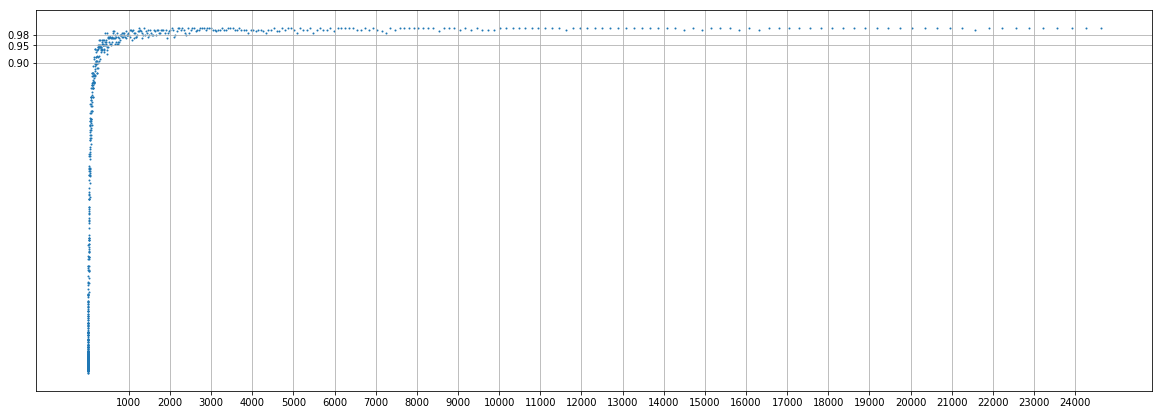

In [180]:
plt.figure(figsize=(20,7))
x = stats.Temp
y = stats.Accept
plt.xticks(range(1000, 25000, 1000))
plt.yticks([0.9, 0.95, 0.98])
plt.scatter(x,y, s=1)
plt.grid()

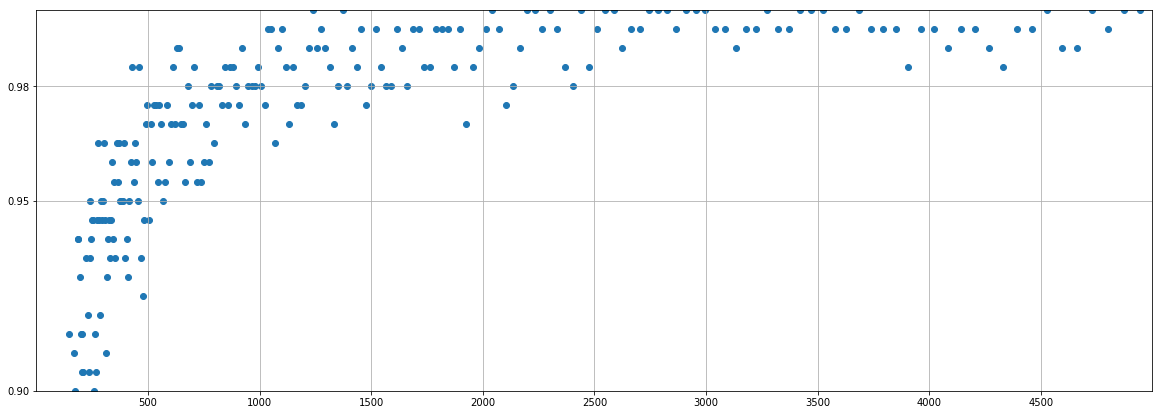

In [181]:
plt.figure(figsize=(20,7))
plt.xlim(0,5000)
plt.ylim(0.9,1)
plt.xticks(range(500, 5000, 500))
plt.yticks([0.9, 0.95, 0.98])
plt.scatter(x,y)
plt.grid()

At least 98% moves are accepted after T=2500, so we set this value as new Tmax

Optimal Tmin value is the one, where energy stops to improve significantly 
Visualising temperature vs. distance to find it

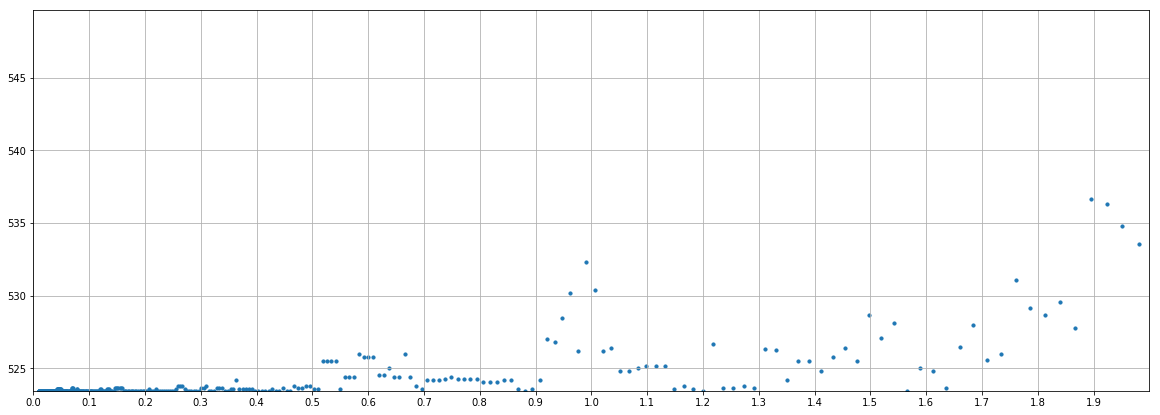

In [185]:
plt.figure(figsize=(20,7))
x = stats.Temp
y = stats.Energy
plt.ylim(min(y),min(y)*1.05)
plt.xlim(0,2)
plt.xticks(np.arange(0, 2, 0.1))
plt.scatter(x,y, s=10)
plt.grid()

Energy reaches minimum and stops decreasing when we reach T = 0.5
We decide Tmin = 0.5

To limit the number of steps we check, at which iteration the energy stops improving

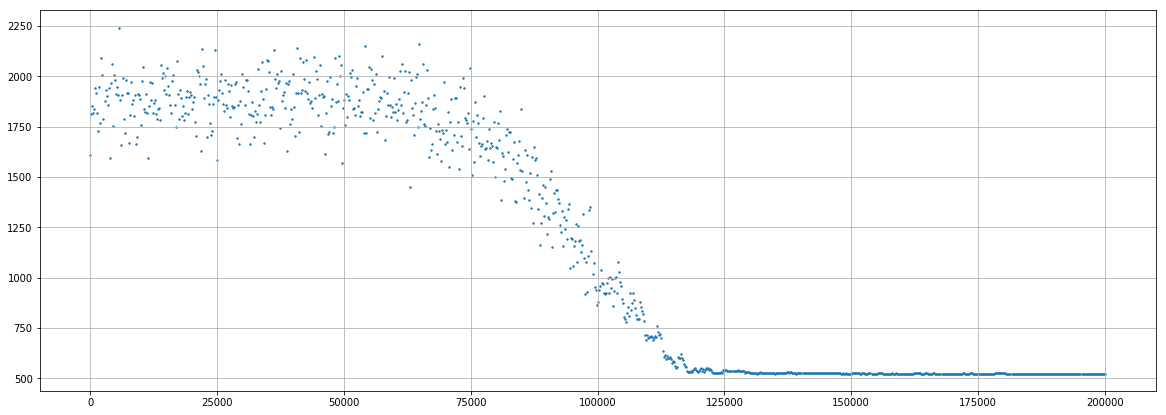

In [186]:
plt.figure(figsize=(20,7))
x = stats.index
y = stats.Energy
plt.scatter(x,y, s=2)
plt.grid()

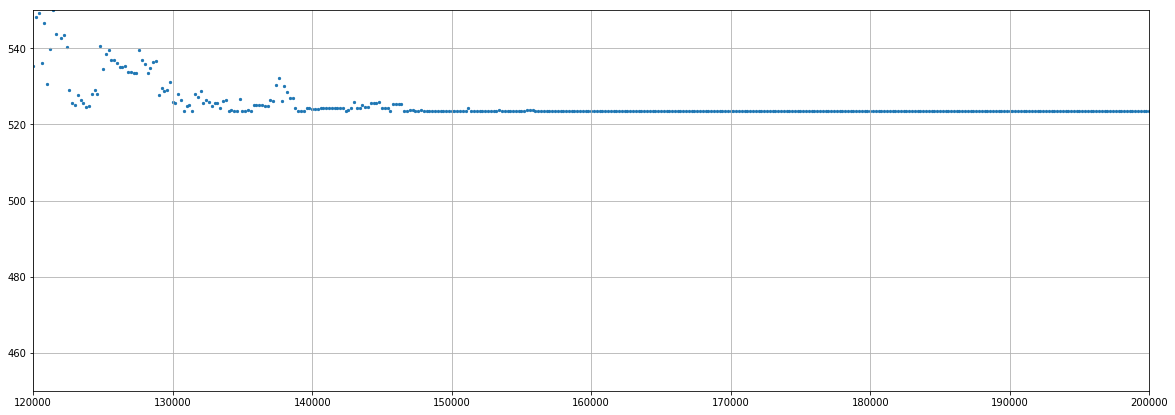

In [187]:
plt.figure(figsize=(20,7))
x = stats.index
y = stats.Energy
plt.ylim(450, 550)
plt.xlim(120000,200000)
plt.scatter(x,y, s=5)
plt.grid()

Energy converges closely to 150000 iterations, we will limit number of steps to this number

### V. Tuned model

Tmin = 0.5
Tmax = 2500
steps = 150000

In [189]:
sequence, energy, stats = annealTSP(init_state, distance_matrix, Tmax=2500, Tmin=0.5, steps=150000)

503 mile route:
0 ➞  9 ➞  13 ➞  20 ➞  28 ➞  24 ➞  25 ➞  29 ➞  31 ➞  34 ➞  36 ➞  37 ➞  32 ➞  33 ➞  35 ➞  30 ➞  26 ➞  27 ➞  23 ➞  21 ➞  22 ➞  19 ➞  14 ➞  12 ➞  5 ➞  7 ➞  8 ➞  15 ➞  17 ➞  18 ➞  16 ➞  11 ➞  10 ➞  6 ➞  4 ➞  2 ➞  3 ➞  1
Computational time: 10.932982206344604


#### Route visualisation

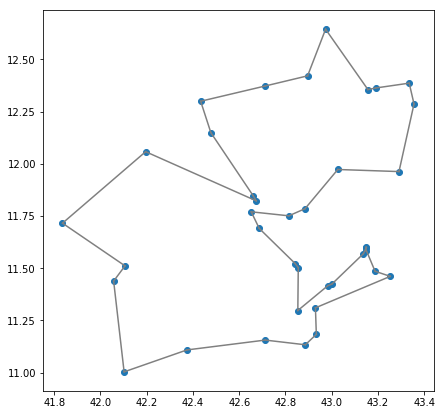

In [190]:
plotRoute(cities, sequence)

#### Convergence curve:

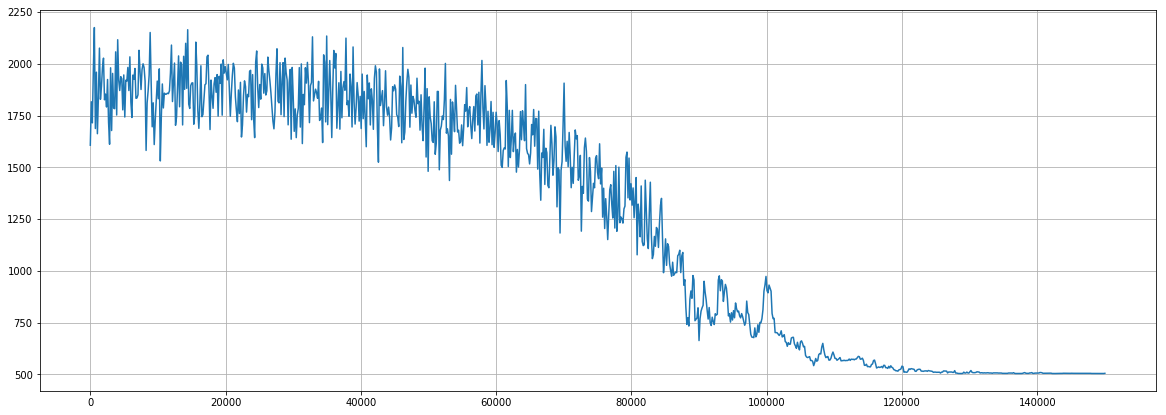

In [191]:
plt.figure(figsize=(20,7))
x = stats.index
y = stats.Energy
plt.plot(x,y)
plt.grid()